In [68]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic.visualizations import plot_time_series, plot_map
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import percentileofscore
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import math

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## Visualizing locations of AWS

In [69]:
aws_file = '/dodrio/scratch/users/vsc35191/WP3/aws_1hour_20190701-20190801.csv'
data = pd.read_csv(aws_file)
data["timestamp"] = data["timestamp"].str.replace("T", " ")
data[['lat', 'lon']] = data['the_geom'].str.extract(r'POINT \(([\d.-]+) ([\d.-]+)\)')
# Convert the new columns to float
data['lat'] = data['lat'].astype(float)
data['lon'] = data['lon'].astype(float)
data['time'] = pd.to_datetime(data["timestamp"])


In [70]:
lookup = pd.DataFrame(np.zeros([2,2]), columns = ["aws_var", "variable"])
lookup["aws_var"].loc[0] = "temp_dry_shelter_avg"
lookup["variable"].loc[0] = "tas"
lookup["aws_var"].loc[1] = "precip_quantity"
lookup["variable"].loc[1] = "pr"

/tmp/ipykernel_1403027/3926502787.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lookup["aws_var"].loc[0] = "temp_dry_shelter_avg"
/tmp/ipykernel_1403027/3926502787.py:2: FutureWarning: Setting an item of incompatible dtype is deprecate

In [71]:
d_coord_points = data[["code", "lat", "lon"]]
d_coord_points = d_coord_points.drop_duplicates()
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [72]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

region = 'europe'

def plot_points_map(d_coord_points: dict, region: str, bounds: str, scale_var = None): 

    # Create a figure and set the projection to PlateCarree
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    if scale_var:
          cmap = plt.cm.Reds
          norm = Normalize(vmin=d_coord_points[scale_var].min(), vmax=d_coord_points[scale_var].max())
          colors = cmap(norm(d_coord_points[scale_var]))
          
    else:
          print("No colorbar will be used")
    # Plot each point and add a label
    for i in np.arange(0, len(d_coord_points)):
         lon = d_coord_points.loc[i, "lon"]
         lat = d_coord_points.loc[i, "lat"]
         key = d_coord_points.loc[i, "code"] 

         if scale_var:
            var_value = d_coord_points.loc[i, scale_var]
            code_color = cmap(norm(var_value))
            ax.scatter(lon, lat, edgecolor='black', s = 50, c = code_color, transform=ccrs.PlateCarree())
         else:
              ax.scatter(lon, lat, color='red', s = 50, transform=ccrs.PlateCarree())
         ax.text(lon + 0.05, lat - 0.05, key, transform=ccrs.PlateCarree())

    # Set extent if needed (optional)
    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    ax.set_title('Location of points', loc='right')
    # Show the plot
    plt.show()
    #fig.savefig("./plots/points_map.png")


No colorbar will be used


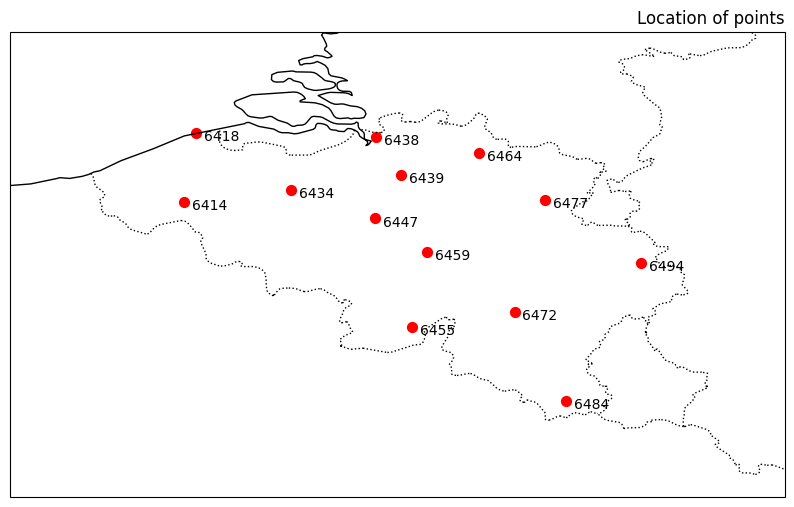

In [73]:
plot_points_map(d_coord_points, "belgium", bounds)

## Visualizing data of AWS

In [74]:
code_point = 6477
data_point = data.loc[np.where(data.code == code_point)[0]]
data_point = data_point.reset_index(drop = True)

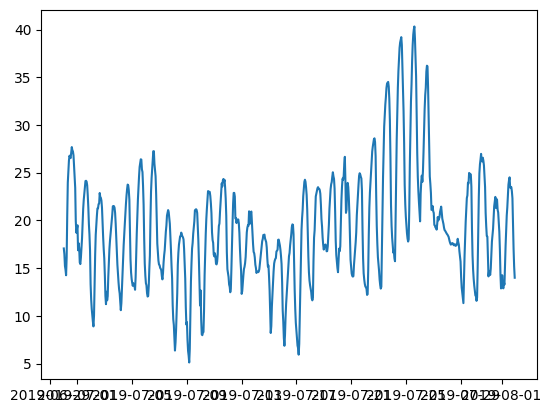

In [75]:
plt.plot(data_point.time, data_point.temp_dry_shelter_avg)

In [76]:
max_data = data.groupby("code").max().reset_index()

In [77]:
d_max_coord_points = max_data[["lat", "lon", "code", "temp_dry_shelter_avg"]]

/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/conda_envs/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/conda_envs/valenspy_dev/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all poin

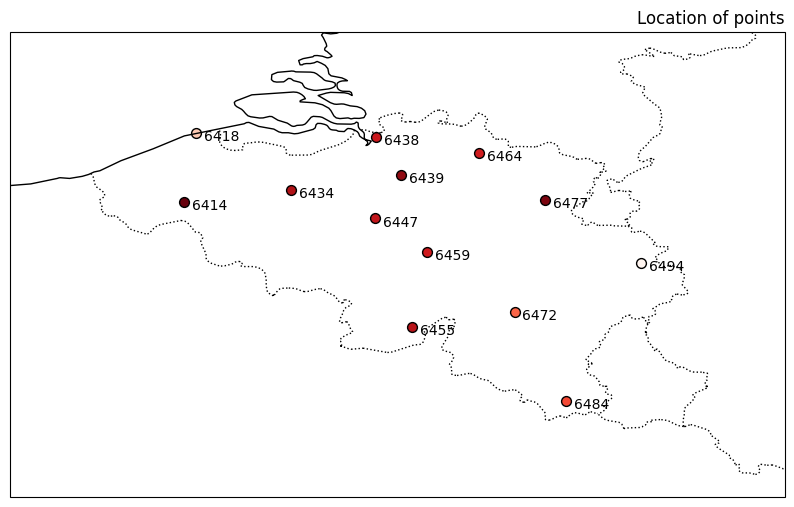

In [78]:
plot_points_map(d_max_coord_points, "belgium", bounds, scale_var = "temp_dry_shelter_avg")